# MedleyDB dataset
This project uses the [MedleyDB dataset](https://medleydb.weebly.com/) V1 (and V2). To get access to the dataset, you need to ask for permission through Zenodo. \
This notebook is created to explore the MedleyDB dataset. There is an overview of the dataset here: https://medleydb.weebly.com/description.html \
Fortunately, the authors provides a sample of the dataset here: https://zenodo.org/record/1438309#.Y9dniuxBy3I. The sample set contains 2 songs from V1:
1. LizNelson_Rainfall
2. Phoenix_ScotchMorris

## Setups
To correctly setup the medleydb library, the `medleydb/medleydb/data/` folder need to have the structure below:
```
medleydb #sub-module
├── medleydb
│   ├── data
│   │   ├── Annotations
│   │   ├── Audio
│   │   └── Metadata
...
```
Simply rename `V1` or `V2` folder after extracting to `Audio` and put it inside the `data/` folder above. \
For the MedleyDB Sample (2 songs) simply copy-paste `Audio` folder into `data/`.

For accessibility, we will try to use only the 2 songs in the sample set for making example.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
import os
import random

If import medleydb return `TypeError: load() missing 1 required positional argument: 'Loader'`, you need to downgrade pyyaml:
```
pyyaml==5.4.1
```

In [7]:
# path to a forked medleydb repo https://github.com/duotien/medleydb
medleydb_repo_path = f"{os.getcwd()}/../medleydb/"
medleydb_data_path = os.path.join(medleydb_repo_path, 'medleydb/data/')
print(medleydb_data_path)
os.environ['MEDLEYDB_PATH'] = medleydb_data_path
import medleydb
from pitch_tracker.utils.medleydb_melody import gen_label

/Users/tien.d/workspace/GITHUB/mono_pitch_tracker/notebooks/../medleydb/medleydb/data/


# Generate annotations
medleyDB also has tools for customizing the annotations. However you need to have the audio for it to work.

In [9]:
HOP = 512*5
output_dir = f'../content/gen_label/{HOP}'
mtracks = medleydb.load_all_multitracks()

for mtrack in mtracks:
    
    # gen_label(mtrack.track_id, output_dir, hop=HOP, overwrite=True, convert_to_midi=True, round_method='round', to_csv=True)
    # gen_label(mtrack.track_id, output_dir, hop=HOP, overwrite=True, convert_to_midi=True, round_method='round', to_csv=False)
    pass

/Users/tien.d/workspace/GITHUB/mono_pitch_tracker/medleydb/medleydb/multitrack.py:371: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


In [10]:
melody_1_path, melody_2_path, *_ = [os.path.join(output_dir, folder_path) for folder_path in os.listdir(output_dir)]

In [11]:
melody_2_annotation_paths = []
for root, folders, files in os.walk(melody_2_path):
    melody_2_annotation_paths.extend([os.path.join(root, fpath) for fpath in files])

In [12]:
sample_annotation_path = random.choice(melody_2_annotation_paths)
print(sample_annotation_path)
df = pd.read_csv(sample_annotation_path, names=['start', 'end', 'midi_value'])
df.head(5)

../content/gen_label/2560/Melody1_midi/AvaLuna_Waterduct.csv


,start,end,midi_value
0,49.806803,49.980952,57.0
1,49.980952,50.039002,58.0
2,50.039002,50.097052,57.0
3,50.097052,50.271202,59.0
4,50.445351,50.503401,60.0


# Visualise
We recommend using Sonic Visualiser to visualize the annotations with audios.

In [13]:
# code to visualize using matplotlib
from matplotlib import pyplot as plt
import librosa
from librosa.display import specshow, waveshow
import torchaudio

In [67]:
def plot_spectrogram(signal: np.ndarray, sample_rate:int, convert_to_mel:bool=False,offset:int=0, n_frame:int=None, f_ratio=1, n_mels:int=108, **stft_params):
    if len(signal.shape) == 1:
        signal = np.expand_dims(signal, axis=0)
    if n_frame is not None:
        signal = signal[:,offset:offset+n_frame]
    
    # Apply FFT & Calculate the Magnitude Spectrum


    if convert_to_mel:
        S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, **stft_params, n_mels=n_mels)
        S_log = librosa.power_to_db(S, ref=np.max)
        y_axis = 'mel'

    else:
        S = librosa.stft(y=signal, **stft_params)
        S_log = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        y_axis = 'linear'

    num_channels, num_frames = signal.shape
    figure, axes = plt.subplots(nrows=num_channels, ncols=1)

    # frequency = np.linspace(0, sample_rate, num_frames)
    # num_frequency_bins = int(len(frequency)*f_ratio)

    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        # axes[c].plot(frequency[:num_frequency_bins], magnitude_spectrum[c,:num_frequency_bins])
        im = specshow(S_log[c], sr=sample_rate, x_axis='time', y_axis=y_axis, ax=axes[c])
        # axes[c].grid(True)
        axes[c].label_outer()
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("Spectrogram")
    figure.colorbar(im, ax=axes, format="%+2.0f dB")

    plt.show(block=False)



In [68]:
audio_path = '../medleydb/medleydb/data/Audio/Phoenix_ScotchMorris/Phoenix_ScotchMorris_MIX.wav'
metadata = torchaudio.info(audio_path)
signal, sample_rate = torchaudio.load(audio_path)

song_duration = metadata.num_frames/metadata.sample_rate # in seconds
m,s = divmod(song_duration, 60)
print(metadata)
print(f'Song duration: {song_duration:.2f}s ({m:.0f}m{s:.0f}s)')

AudioMetaData(sample_rate=44100, num_frames=7811926, num_channels=2, bits_per_sample=16, encoding=PCM_S)
Song duration: 177.14s (2m57s)


In [69]:
stft_params = {
    'n_fft': 1024,
    'win_length': None,
    'hop_length': 512,
    'window': "hann",
    'center': True,
    'dtype': None,
    'pad_mode': "constant",
}


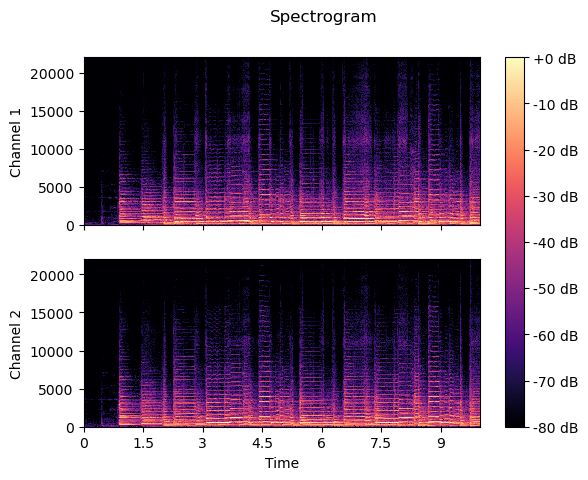

In [74]:
plot_spectrogram(signal.numpy(), sample_rate, convert_to_mel=False, offset=0, n_frame=10*sample_rate, **stft_params)